# Init

In [50]:
import collections


## Dataset-specific -- edit me
data_number = "082"
data_name = "Final"

treatments = collections.OrderedDict()
treatments['control'] = 'control'
treatments['noreward'] = 'benign'
treatments['punish'] = 'harsh'

## basic config
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/ALife\ CE\ Paper/alife2016/evo_mod/"
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/Journal\ CE\ Paper/data_analysis/"
base_path = "/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/"

raw_data_directory = "raw_data"
analysis_directory = "intermediate_data"
scripts_path = "~/Dropbox/School_Docs/Research/research_scripts/"

## generated
data_directory = data_number + "_" + "_".join(data_name.split(" "))
data_path = base_path + raw_data_directory + "/" + data_directory
analysis_path = base_path + analysis_directory

print (data_path)
print (analysis_path)



/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


In [51]:
%cd {data_path}
%mkdir {analysis_path}
%cd {analysis_path}
%pwd


/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
mkdir: cannot create directory ‘/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data’: File exists
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


u'/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data'

In [52]:
import glob


import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy  
import scikits.bootstrap as bootstrap
from scipy import stats
import matplotlib.gridspec as gridspec
#from IPython.display import Image
from PIL import Image
from IPython.display import Image as ipyImage

%matplotlib inline
%rehashx
pd.__version__

u'0.20.3'

In [53]:
import sys
sys.path.append({scripts_path})
%run {scripts_path}/quickplot.py --help

Usage: quickplot.py [options] outfile [input_file1 column1 "directory_glob1" name1 .. input_fileN columnN "directory_globN" nameN] 
          


Options:
  -h, --help            show this help message and exit
  -v, --verbose         print extra messages to stdout
  -d, --debug_messages  print debug messages to stdout
  --plotonly            Skip the aggregation step, and plot only, using
                        existing data files.
  --noplot              Skip the plotting step, only aggregate the data files.
  -t TITLE, --title=TITLE
                        set a different title than outfile (default)
  -x XLABEL, --xlabel=XLABEL
                        X-axis Label
  -y YLABEL, --ylabel=YLABEL
                        Y-axis Label
  --include_chevrons    Include line marker glyphs in addition to color
  --chevrons_by_members
                        Make the chevrons track by members, along with line
                        style
  --data_members=MEMBER_COUNT
                        N

# 1Step - Filtered

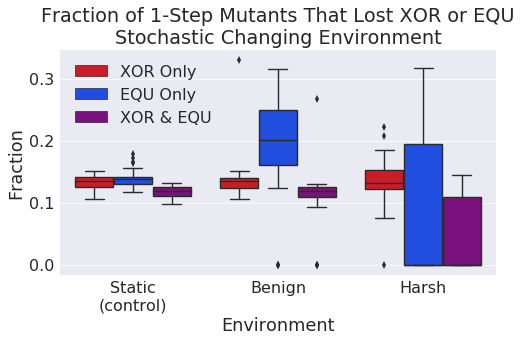

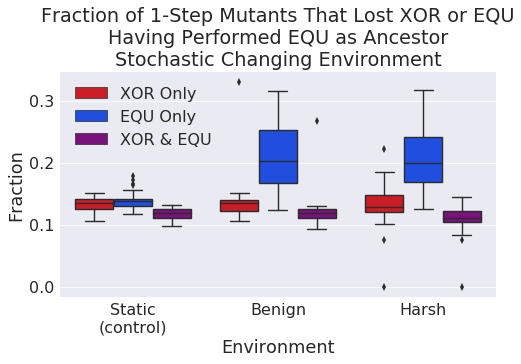

In [76]:
subdir = "../202_StochasticCE__MutLandscape_1Step/"


tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}

dfs = []
for treatment in treatments:
    filepath = data_path + "/" + subdir + treatment + "_env/data/mutation_landscape_metrics__ancestor_EQU_only.csv"
    filepath = filepath.replace("\\", "")

    df = pd.read_csv(filepath, sep=",", header=None, comment="#", skip_blank_lines=True,                
                     usecols=[10, 11, 12, 15],                
                     names=["XOR Only", "EQU Only", "XOR & EQU", "Does_EQU"])
    
    df = pd.melt(df, id_vars=["Does_EQU"], value_name="Fraction", var_name=["Type"])
    df['Environment'] = [tname[treatment]] * len(df)
    dfs.append(df)
    
combined = pd.concat(dfs)

sns.set(#style="whitegrid", 
        color_codes=True, 
        palette="bright"
)
sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Fraction",
                   hue="Type",
                   data=combined,
                   size=5, aspect=1.5, #
                   palette={"EQU Only": "b", 
                            "XOR Only": "r",
                            "XOR & EQU": "#89008E"},
                   kind="box", 
                   legend=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Fraction of 1-Step Mutants That Lost XOR or EQU\nStochastic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    #ax.set_ylim([-0.01,0.35])
    #ax.set_ylim([0,0.35])
    
L=plt.legend(loc="upper left")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### filter out
plt.show()
filtered = combined.loc[combined["Does_EQU"] == 1]

filtered.to_pickle("202_SCE_MutLand_1Step__filtered.pd.pickle")

sns.set(#style="whitegrid", 
        color_codes=True, 
        palette="bright"
)
sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Fraction",
                   hue="Type",
                   data=filtered,
                   size=5, aspect=1.5, #
                   palette={"EQU Only": "b", 
                            "XOR Only": "r",
                            "XOR & EQU": "#89008E"},
                   kind="box", 
                   legend=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Fraction of 1-Step Mutants That Lost XOR or EQU\nHaving Performed EQU as Ancestor\nStochastic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    #ax.set_ylim([-0.01,0.35])
    #ax.set_ylim([0,0.35])
    
L=plt.legend(loc="upper left")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



# Stats

In [55]:
def mww(a, b, nameA, nameB, title, field):
    print
    print title + " - " + nameA + " vs " + nameB
    print "-----------------"
    print stats.ranksums(a[field], b[field]) 
    z_stat, p_val = stats.ranksums(a[field], b[field])  

    #print (z_stat)
    #print (p_val)

    if p_val < (0.05/3): #bonferroni
        print ("reject null of sameness (different)")
    else:
        print ("can't reject null of sameness")
    print "medians"
    print nameA, a[field].median()
    print nameB, b[field].median()

def kruskal(a, b, c, field, verbose=False):
    x = a[field].dropna()
    y = b[field].dropna()
    z = c[field].dropna()    

    if verbose:
        print a[field].describe()
        print b[field].describe()
        print c[field].describe()
        print
        print x
        print y
        print z
    
    print stats.kruskal(x, y, z)

In [85]:
## Read and set up the CCE pickle
CCE_1step = pd.read_pickle('203_CCE_MutLand_1Step.pd.pickle')
#print CCE_1step.describe()
#print CCE_1step.head()

CCE_equonly = CCE_1step.loc[CCE_1step['Type'] == "EQU Only"]

CCE_stat = CCE_equonly.loc[CCE_equonly['Environment'] == 'Static\n(control)']
CCE_ben = CCE_equonly.loc[CCE_equonly['Environment'] == 'Benign']
CCE_har = CCE_equonly.loc[CCE_equonly['Environment'] == 'Harsh']

In [86]:
## Read and set up the CCE pickle

SCE_1step = pd.read_pickle("202_SCE_MutLand_1Step__filtered.pd.pickle")
#print SCE_1step.describe()
#print SCE_1step.head()

SCE_equonly = SCE_1step.loc[SCE_1step['Type'] == "EQU Only"]

SCE_stat = SCE_equonly.loc[SCE_equonly['Environment'] == 'Static\n(control)']
SCE_ben = SCE_equonly.loc[SCE_equonly['Environment'] == 'Benign']
SCE_har = SCE_equonly.loc[SCE_equonly['Environment'] == 'Harsh']

In [87]:
mww(CCE_stat, SCE_stat, "Cyclic", "Stochastic", 'Static Env', 'Fraction')
mww(CCE_ben, SCE_ben, "Cyclic", "Stochastic", 'Benign Env', 'Fraction')
mww(CCE_har, SCE_har, "Cyclic", "Stochastic", 'Harsh Env', 'Fraction')


Static Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=0.32021856444479335, pvalue=0.74880265115559008)
can't reject null of sameness
medians
Cyclic 0.137434955617
Stochastic 0.138047138047

Benign Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=-2.4179177520083086, pvalue=0.015609604652827416)
reject null of sameness (different)
medians
Cyclic 0.177532904805
Stochastic 0.20202020202

Harsh Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=0.95351483233975209, pvalue=0.340329284717792)
can't reject null of sameness
medians
Cyclic 0.217018671564
Stochastic 0.198500153046


In [88]:
mww(SCE_ben, SCE_har, "Benign", "Harsh", 'Stochastic', 'Fraction')
mww(SCE_stat, SCE_har, "Static", "Harsh", 'Stochastic', 'Fraction')


Stochastic - Benign vs Harsh
-----------------
RanksumsResult(statistic=0.076249285166302333, pvalue=0.93922077289161598)
can't reject null of sameness
medians
Benign 0.20202020202
Harsh 0.198500153046

Stochastic - Static vs Harsh
-----------------
RanksumsResult(statistic=-5.6959425747407959, pvalue=1.2269217180655923e-08)
reject null of sameness (different)
medians
Static 0.138047138047
Harsh 0.198500153046


In [89]:
mww(CCE_ben, CCE_har, "Benign", "Harsh", 'Cyclic', 'Fraction')
mww(CCE_stat, CCE_ben, "Static", "Benign", 'Cyclic', 'Fraction')
mww(CCE_stat, CCE_har, "Static", "Harsh", 'Cyclic', 'Fraction')


Cyclic - Benign vs Harsh
-----------------
RanksumsResult(statistic=-3.4946504548928154, pvalue=0.00047468298128305788)
reject null of sameness (different)
medians
Benign 0.177532904805
Harsh 0.217018671564

Cyclic - Static vs Benign
-----------------
RanksumsResult(statistic=-5.4623329539594403, pvalue=4.6991765180563988e-08)
reject null of sameness (different)
medians
Static 0.137434955617
Benign 0.177532904805

Cyclic - Static vs Harsh
-----------------
RanksumsResult(statistic=-7.8033744662949811, pvalue=6.0273359092304226e-15)
reject null of sameness (different)
medians
Static 0.137434955617
Harsh 0.217018671564


# Stoch Env - 2-Step Regain EQU - Figure 11

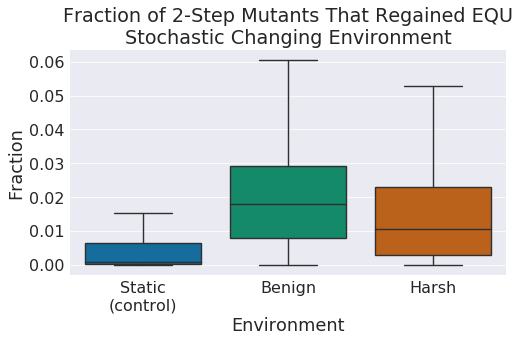

In [77]:
subdir = "../204_StochasticCE__MutLandscape_2ndStep/"


tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}

dfs = []
for treatment in treatments:
    filepath = data_path + "/" + subdir + treatment + "__mutation_landscape_metrics.csv"
    filepath = filepath.replace("\\", "")

    df = pd.read_csv(filepath, sep=",", header=None, usecols=[8],
                names=["Regained EQU"],
                comment="#",
                skip_blank_lines=True,
                )
    
    df = pd.melt(df, value_name="Fraction", var_name=["Type"])
    df['Environment'] = [tname[treatment]] * len(df)
    dfs.append(df)
    
combined = pd.concat(dfs)

combined.to_pickle("204_SCE_MutLand_2Step.pd.pickle")

sns.set(#style="whitegrid", 
        color_codes=True, 
        palette="colorblind"
)
sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Fraction",
                   #hue="Type",
                   data=combined,
                   size=5, aspect=1.5, #
                   #palette={"Regained EQU": "b"},
                   kind="box", 
                   legend=False,
                   showfliers=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Fraction of 2-Step Mutants That Regained EQU\nStochastic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# Stats

In [90]:
## Read and set up the CCE pickle
CCE_2step = pd.read_pickle('205_CCE_MutLand_2Step.pd.pickle')
#print CCE_2step.describe()
#print CCE_2step.head()

CCE_equonly = CCE_2step.loc[CCE_2step['Type'] == "Regained EQU"]

CCE_stat = CCE_equonly.loc[CCE_equonly['Environment'] == 'Static\n(control)']
CCE_ben = CCE_equonly.loc[CCE_equonly['Environment'] == 'Benign']
CCE_har = CCE_equonly.loc[CCE_equonly['Environment'] == 'Harsh']

In [91]:
## Read and set up the CCE pickle

SCE_2step = pd.read_pickle("204_SCE_MutLand_2Step.pd.pickle")
#print SCE_1step.describe()
#print SCE_1step.head()

SCE_equonly = SCE_2step.loc[SCE_2step['Type'] == "Regained EQU"]

SCE_stat = SCE_equonly.loc[SCE_equonly['Environment'] == 'Static\n(control)']
SCE_ben = SCE_equonly.loc[SCE_equonly['Environment'] == 'Benign']
SCE_har = SCE_equonly.loc[SCE_equonly['Environment'] == 'Harsh']

In [93]:
mww(CCE_stat, SCE_stat, "Cyclic", "Stochastic", 'Static Env', 'Fraction')
mww(CCE_ben, SCE_ben, "Cyclic", "Stochastic", 'Benign Env', 'Fraction')
mww(CCE_har, SCE_har, "Cyclic", "Stochastic", 'Harsh Env', 'Fraction')


Static Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=4.3601325119134655, pvalue=1.2998370548258283e-05)
reject null of sameness (different)
medians
Cyclic 0.000918273645546
Stochastic 0.000612182430364

Benign Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=-18.429226543324006, pvalue=7.6569938414308347e-76)
reject null of sameness (different)
medians
Cyclic 0.0131619222528
Stochastic 0.0180593816957

Harsh Env - Cyclic vs Stochastic
-----------------
RanksumsResult(statistic=12.758667957562485, pvalue=2.7892999826827874e-37)
reject null of sameness (different)
medians
Cyclic 0.013468013468
Stochastic 0.0104071013162


In [94]:
mww(SCE_ben, SCE_har, "Benign", "Harsh", 'Stochastic', 'Fraction')
mww(SCE_stat, SCE_ben, "Static", "Benign", 'Stochastic', 'Fraction')
mww(SCE_stat, SCE_har, "Static", "Harsh", 'Stochastic', 'Fraction')


Stochastic - Benign vs Harsh
-----------------
RanksumsResult(statistic=20.164168508623646, pvalue=2.0211557189803541e-90)
reject null of sameness (different)
medians
Benign 0.0180593816957
Harsh 0.0104071013162

Stochastic - Static vs Benign
-----------------
RanksumsResult(statistic=-64.421127379370944, pvalue=0.0)
reject null of sameness (different)
medians
Static 0.000612182430364
Benign 0.0180593816957

Stochastic - Static vs Harsh
-----------------
RanksumsResult(statistic=-48.669571521911777, pvalue=0.0)
reject null of sameness (different)
medians
Static 0.000612182430364
Harsh 0.0104071013162


In [95]:
mww(CCE_ben, CCE_har, "Benign", "Harsh", 'Cyclic', 'Fraction')
mww(CCE_stat, CCE_ben, "Static", "Benign", 'Cyclic', 'Fraction')
mww(CCE_stat, CCE_har, "Static", "Harsh", 'Cyclic', 'Fraction')


Cyclic - Benign vs Harsh
-----------------
RanksumsResult(statistic=-11.350491485977518, pvalue=7.3746991569147637e-30)
reject null of sameness (different)
medians
Benign 0.0131619222528
Harsh 0.013468013468

Cyclic - Static vs Benign
-----------------
RanksumsResult(statistic=-47.900219393560519, pvalue=0.0)
reject null of sameness (different)
medians
Static 0.000918273645546
Benign 0.0131619222528

Cyclic - Static vs Harsh
-----------------
RanksumsResult(statistic=-57.822921730422301, pvalue=0.0)
reject null of sameness (different)
medians
Static 0.000918273645546
Harsh 0.013468013468
